# Using astroquery module to query *Vizier* tables

Astronomy is observational science, so data exploration is an important aspect of it. As the amount of astronomical data exponentially increases the necessity to be able to explore the available data becomes more and more obvious, so there are many large-scale projects aiming to make data and catalogs available. The largest one is *Vizier*, which provides the most complete library of published astronomical catalogues, tables and associated data, with verified and enriched data, accessible via multiple interfaces. Today we'll learn how to acces that using *astroquery* module. In a first project, let's try to find which of the rotationally-powered pulsars were observed and detected by XMM-Newton

In [2]:
from astroquery.vizier import Vizier # import the Vizier module from astroquery
from pylab import *

# The simplest way to query an object is via
result = Vizier.query_object("Crab", catalog='B/psr')
# if you omit catalog argument, it will query all of the catalogs available on Vizier. The result is list of tables
print(result)
# The catalog we are using is a well-known ATNF Pulsar catalog, 
# the details about it can be found either in the original paper (most)
# or in the Vizier summary page https://cdsarc.unistra.fr/viz-bin/cat/B/psr

TableList with 1 tables:
	'0:B/psr/psr' with 21 column(s) and 1 row(s) 


In [3]:
# You can access individual tables (which are VOTables) in the list either by name or index
print(result[0])
print("\n\n") # Some empty space
print(result['B/psr/psr'])

   PSRJ    r_PSRJ   RAJ2000     DEJ2000   ... r_DistDM      Age        Edot  
                    "h:m:s"     "d:m:s"   ...                yr      1e-07 W 
---------- ------ ----------- ----------- ... -------- ------------- --------
J0534+2200   sr68 05 34 31.97 +22 00 52.1 ...     tc93        1260.0    4e+38



   PSRJ    r_PSRJ   RAJ2000     DEJ2000   ... r_DistDM      Age        Edot  
                    "h:m:s"     "d:m:s"   ...                yr      1e-07 W 
---------- ------ ----------- ----------- ... -------- ------------- --------
J0534+2200   sr68 05 34 31.97 +22 00 52.1 ...     tc93        1260.0    4e+38


In [4]:
# You can also get list of columns which are stored in your result
print(result[0].colnames)

['PSRJ', 'r_PSRJ', 'RAJ2000', 'DEJ2000', 'Plx', 'e_Plx', 'r_Plx', 'P0', 'e_P0', 'r_P0', 'DM', 'e_DM', 'r_DM', 'S400', 'e_S400', 'r_S400', 'Dist', 'DistDM', 'r_DistDM', 'Age', 'Edot']


In [5]:
# You can also specify which fields you're actually interested in
# that's particularly important when default set of returned fields is missing field of interest
v = Vizier(columns=['PSRJ','RA2000', 'DE2000','P0','P1','DM','Type'])
# Here I explicitly said that we are interested in name, equatorial coordinates, spin period and it's derivative,
# dispersion measure and Type of the pulsar. Again, see columns in catalog's readme file
result = v.query_object("Crab", catalog='B/psr')
print(result[0])

        P1           PSRJ      RA2000  ...      DM               Type         
                                deg    ...   pc / cm3                         
----------------- ---------- --------- ... ----------- -----------------------
      4.20972e-13 J0534+2200  83.63322 ...   56.791000 HE[cdt69,fhm+69,hjm+70]


Now you could also query list of objects, for instance by names, or even all objects contained in a given table. What we are interested, however, is to get the entire catalog. To do that, we use another function, but first let's again set number of returned rows to -1 (this time for our query object)

In [6]:
v.ROW_LIMIT=-1
atnf = v.get_catalogs('B/psr')
print(atnf[0])

        P1            PSRJ      RA2000  ...      DM        Type   
                                 deg    ...   pc / cm3            
----------------- ----------- --------- ... ----------- ----------
        2.097e-15  J0006+1834   1.52000 ...   12.000000           
       3.6039e-13  J0007+7303   1.75708 ...          --       NRAD
       5.6446e-16  J0014+4746   3.57396 ...   30.850000           
               --  J0023+0923   5.82033 ...   14.300000         HE
       -4.985e-20 J0024-7204C   5.95980 ...   24.599000           
        -3.43e-21 J0024-7204D   6.05783 ...   24.729000           
       9.8509e-20 J0024-7204E   6.04627 ...   24.230000           
         6.45e-20 J0024-7204F   6.01606 ...   24.379000           
       -4.215e-20 J0024-7204G   6.03316 ...   24.441000           
       -1.835e-21 J0024-7204H   6.02792 ...   24.360000           
              ...         ...       ... ...         ...        ...
      4.63038e-15  J2330-2005 352.61202 ...    8.456000       

Now we can do some fun stuff like making the famous $P-\dot{P}$ diagram for rotational-powered pulsars.

Text(0, 0.5, '$\\dot{P}$, s s$^{-1}$')

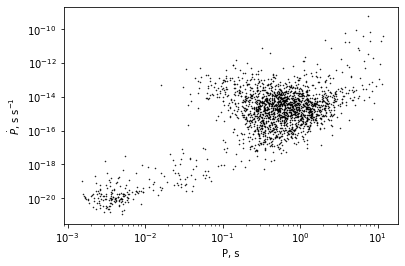

In [7]:
# Get period and period derivative
p_spin = atnf[0]['P0'].data.data
pdot_spin = atnf[0]['P1'].data.data
loglog(p_spin,pdot_spin,'k.',ms=1)
xlabel('P, s')
ylabel('$\dot{P}$, s s$^{-1}$')

In context of our today's lecture we would like, however, to know which of these objects have been detected with XMM. To do that, we'll use another service called *Xmatch* which is designed to match catalogues on server-side. Here we take ATNF catalog and match it against XMM-Newton serendipious source catalog. Note that in principle Xmatch allows also uploading user tables (i.e. we could just suply atnf\[0\] table as first argument, however, astropy interface is a bit buggy in this regard (it needs to upload table to Vizier first, which takes space etc), so for larger queries with user tables it is better to use Xmatch web interface or write a loop matching table rows one by one or in small segments

In [8]:
from astroquery.xmatch import XMatch
import astropy.units as u
match = XMatch.query(cat1='vizier:B/psr/psr', cat2='vizier:IX/55/xmm3r8s',max_distance=5*u.arcsec,colRA1='RA2000',colDec1='RAJ2000')
print(match)

Could not import regions, which is required for some of the functionalities of this module.
angDist   _RAJ2000_1  _DEJ2000_1    PSRJ    ... detID  xcatDBdet xcatDB IRAP
-------- ----------- ----------- ---------- ... ------ --------- ------ ----
1.627868   1.7570833  73.0520556 J0007+7303 ...   2967 xcatDBdet xcatDB IRAP
0.249925   7.6142842   4.8610308 J0030+0451 ...   9770 xcatDBdet xcatDB IRAP
 0.92187   8.5909506  -5.5768389 J0034-0534 ...  11094 xcatDBdet xcatDB IRAP
0.646705  15.1792917 -72.1926667 J0100-7211 ...  39069 xcatDBdet xcatDB IRAP
0.285829  17.0347792 -14.5306075 J0108-1431 ...  45394 xcatDBdet xcatDB IRAP
0.666017  19.4110875  59.2439972 J0117+5914 ...  51475 xcatDBdet xcatDB IRAP
0.183825  26.5934167  61.7507778 J0146+6145 ...  67500 xcatDBdet xcatDB IRAP
0.631748  31.4080103  64.8281483 J0205+6449 ...  75785 xcatDBdet xcatDB IRAP
1.107879  34.5264942  42.5381597 J0218+4232 ...  85920 xcatDBdet xcatDB IRAP
0.329566  54.4326078  17.2541189 J0337+1715 ... 140852 xcatDB

As you can see, 188 pulsars from the catalog appear to be detected by XMM. The result table contains basic information from both catalogues, i.e. pulsar parameters but also X-ray fluxes. We can play with this data, for instance check where the X-ray emitting pulsars appear on $P-\dot{P}$ diagram we had before. Unfortunately *Xmatch* result only contains *some* parameters (i.e. not P1 in our case), so a little trick is needed here to get missing information from original catalogue

Text(0, 0.5, '$\\dot{P}$, s s$^{-1}$')

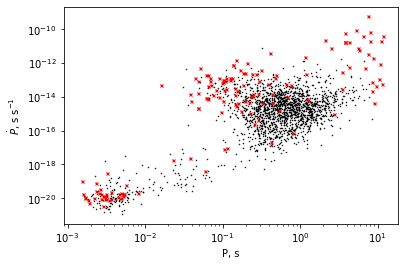

In [10]:
p_spin = atnf[0]['P0'].data.data
pdot_spin = atnf[0]['P1'].data.data
loglog(p_spin,pdot_spin,'k.',ms=1)
orig_id = atnf[0]['PSRJ'].data.data
match_id = match['PSRJ'].data
match_index = concatenate([where(orig_id==x)[0] for x in match_id])
loglog(p_spin[match_index],pdot_spin[match_index],'rx',ms=3)
xlabel('P, s')
ylabel('$\dot{P}$, s s$^{-1}$')

Of course, XMM catalog also contains fluxes, hardness ratios etc, so you could explore, for instance, how X-ray brightness of a given pulsar correlates with it's spin-down luminosity, age, or whatever. If you needed, you could include another catalogue like Gaia DR3 to get distances or some other parameters of interest.

# Cross-matching the data to catalogs and finding the data
Now you could be interested also to analyze XMM data for some of those objects. Note that some of the catalogs may contain, for instance, all detection from a given source, which can be sufficient, i.e. to make it's lightcurve. Thes points can be also obtained by querying vizier as before. Now we are interested in getting actual data, however. To do that you need to find observation id for each of the sources of interest. 

### Searching for XMM data and getting some images
You can do this by searching B/xmm table in Vizier, or using API provided by XSA. However, there are also other ways which I'd like to illustrate, so we'll not do that. One possibility is to use heasarc module from astroquery. It's specifically geared towards accessing this data archive in a uniform way, so could also be used to search for data from other missions. Let's assume we want to search for data for first match we've got before

In [11]:
from astroquery.heasarc import Heasarc # import the module
heasarc = Heasarc() # create heasarc object
mission = 'xmmmaster' # define table to search, see https://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/w3catindex.pl for full list
object_name = '%s %s'%(match[0]['_RAJ2000_1'],match[0]['_DEJ2000_1']) # get coordinates for first match to search by coordinates
print(object_name)
object_name1 = 'PSR %s'%(match[0]['PSRJ']) # or get PSR name to search by name
print(object_name1)
# query heasarc for XMM data
res = heasarc.query_object(object_name1, mission=mission) # choose your pick. Keep in mind that Simbad must be able to resolve the name you give
# print the result
print(res)

1.7570833 73.0520556
PSR J0007+7303
  OBSID     STATUS  NAME ... PUBLIC_DATE DATA_IN_HEASARC      SEARCH_OFFSET_    
                         ...     MJD                                            
---------- -------- ---- ... ----------- --------------- -----------------------
0604940201 ARCHIVED CTA1 ...       55350 Y               8.219 (PSR J0007+7303)

0604940101 ARCHIVED CTA1 ...       55350 Y               8.219 (PSR J0007+7303)

0011430201 ARCHIVED CTA1 ...       52824 Y               8.374 (PSR J0007+7303)



As you can see, there are 3 observations returned for this one. So how do we proceed from here? Depends on what you want to do. You could, for instance, download the entire observation using *astroquery.esa.xmm_newton* module, and then write a python function to analyze this observation and extract source spectrum/lightcurve (in particular, using *astroquery.esa.xmm_newton.XMMNewton.download_data* function). That's a bit too large of a download, however, so now let's just get a *postcard* image of the region using the same module

Created TAP+ (v1.2.1) - Connection:
	Host: nxsa.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
INFO: Copying file to P0604940101EPX0003COLIM8000.PNG... [astroquery.esa.xmm_newton.core]


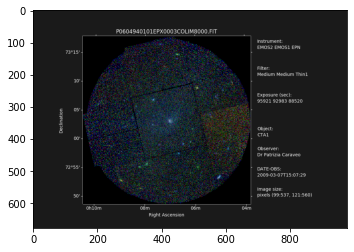

In [12]:
from astroquery.esa.xmm_newton import XMMNewton
imshow(imread(XMMNewton.get_postcard(res['OBSID'][1])))

Alternatively more direct access to XMM data is possible via heasarc (simple FTP). You just need to construct URL appropriate to for your needs (i.e. get correct file). For instance, we could get MOS1 image of the field. That's part of pipeline products and URL we are interested in can be constructed knowing that and obsid:

In [11]:
obsid = res['OBSID'][1]
url="https://heasarc.gsfc.nasa.gov/FTP/xmm/data/rev0/%s/PPS/P%sM1S001IMAGE_8000.FTZ"%(obsid,obsid)
print(url)
import astropy.io.fits as pyfits
hdu = pyfits.open(url)

https://heasarc.gsfc.nasa.gov/FTP/xmm/data/rev0/0604940101/PPS/P0604940101M1S001IMAGE_8000.FTZ


Now we can work with it (unlike the postcard image above). For instance, we can convolve the image, rescale it and plot

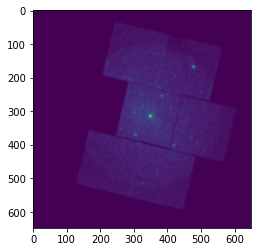

In [12]:
import astropy.convolution
imshow(astropy.convolution.convolve(hdu[0].data,astropy.convolution.kernels.Gaussian2DKernel(2)))

Obviously, we could plot in sky coordinates or do more advanced analysis as done in previous lecture, the image is yours already. Often you don't need more than pipeline products, so being able to machine access to those is a very valuable ability. Note that source spectra are also part of pipeline products for XMM/Chandra, so it often makes sense to start at least quick exploration of the data by looking at those and only do more advanced analysis afterwards.

### Find SNRs observed by *Chandra*

Again, can be done using *Xmatch* service to know what to look for. Note that same SNR could have observed multiple times, so we'd like just to get SNR name column and get unique sources out of that

In [18]:
match = XMatch.query(cat1='vizier:VII/284/snrs', cat2='vizier:B/chandra/chandra',max_distance=150*u.arcsec,colRA1='RAJ2000',colDec1='DEJ2000',colRA2='RAJ2000',colDec2='DEJ2000')
print(match)
snrs = unique(match['SNR'].data)
print("So, in the end chandra observed following SNRs\n")
print(snrs)

 angDist   _RAJ2000_1 _DEJ2000_1 ... DEJ2000_2   Status         ObsDate      
---------- ---------- ---------- ... --------- ---------- -------------------
 53.507216   266.4333      -29.0 ... -29.00306   archived 2005-10-20T18:18:58
 53.507216   266.4333      -29.0 ... -29.00306   archived 2007-07-24T11:32:07
 53.507216   266.4333      -29.0 ... -29.00306   archived 2005-06-05T03:32:15
 53.507216   266.4333      -29.0 ... -29.00306   archived 2008-05-10T23:41:23
 53.507216   266.4333      -29.0 ... -29.00306   archived 2008-07-15T22:38:00
 57.393767   266.4333      -29.0 ... -29.00789   archived 2013-04-29T15:13:05
 57.393767   266.4333      -29.0 ... -29.00789   archived 2013-10-23T08:53:23
 57.393767   266.4333      -29.0 ... -29.00789   archived 2013-05-12T10:37:43
 57.393767   266.4333      -29.0 ... -29.00789   archived 2013-06-04T08:44:10
 58.960063   266.4333      -29.0 ... -29.00781   archived 2013-06-09T04:25:10
       ...        ...        ... ...       ...        ...       

Of course, you could do the same with XMM/Swift XRT and get a full list of SNRs observed in X-rays so far. More interesting in this case could be to look for ones which were *not* yet observed, and prepare a proposal to observe them :)

### Make mission-long RXTE lightcurve of X Per
Of course, we can access also mission from non-imaging missions, for instance RXTE. When we're talking about individual sources, Vizier is not that useful, so this part we can do simply using heasarc submodule of astroquery.

/Users/doroshv/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Count-rate, counts/s (full band)')

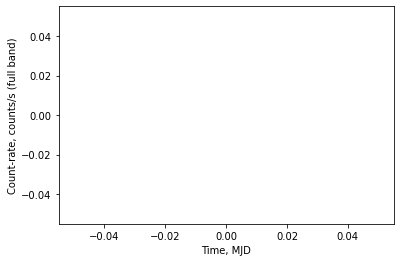

In [14]:
res = heasarc.query_object('X Per', mission='xtemaster')
obsids = res['OBSID'].data.astype('str')
def get_time_countrate(obsid):
    try:
        pid="P%s"%obsid.split('-')[0]
        if int(pid[1:3])<=90:
            ao='AO'+pid[1:2]
        else:
            ao='AO'+str(9+int(pid[2:3]))
        speurl = "https://heasarc.gsfc.nasa.gov/FTP/rxte/data/archive/%s/%s/%s/stdprod/xp%s_s2.pha.gz"%(ao,pid,obsid,obsid.replace('-',''))
        counts = sum(pyfits.getdata(speurl).field('counts'))
        exposure = pyfits.getval(speurl,'exposure',1)
        tstart = pyfits.getval(speurl,'tstart',1)/86400. + pyfits.getval(speurl,'mjdrefi',1) + pyfits.getval(speurl,'mjdreff',1)
        return tstart,counts/exposure, sqrt(counts)/exposure
    except:
        return nan, nan, nan

time, rate, error = transpose([get_time_countrate(x) for x in obsids])
errorbar(time,rate,error,fmt='k.')
xlabel('Time, MJD')
ylabel('Count-rate, counts/s (full band)')

Here we estimated countrate based on spectral files, but lightcurves could be accessed in a similar way, which would allow to check for pulsations etc. The message given by this example is that even if there's no dedicated API, you can always access data "manually", i.e. if you know the structure of data archive (and that's documented), you can write a function to get what you want out of the archive. Again, pipeline products are often sufficient for your scientific goals, and working like that is much faster than downloading/analyzing all observations